# Start

# Importing packages

In [1]:
# !pip install tensorflow
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from datetime import datetime
import shutil

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
# The preprocess functions from resnet50 and inception_v3 are not used bec the preprocess_input_vgg16 provided the best results.



# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
tf.__version__

'2.19.1'

# Data loading

In [3]:
df = pd.read_csv('../Dataset+projet+pretraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

## Filtring category

In [4]:
print(df['product_category_tree'].value_counts())

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1

In [5]:
# Inspecter la structure des données de catégorie
print(df['product_category_tree'].iloc[0])

# Nettoyer et extraire la catégorie principale
def extract_main_category(category_tree):
    if pd.isna(category_tree):
        return "Unknown"

    # Supprimer les caractères [""] et diviser par >>
    try:
        # Enlever les crochets et guillemets
        clean_tree = category_tree.strip('[]"')
        # Diviser par >>
        categories = clean_tree.split(">>")
        # Prendre la première catégorie (niveau principal) et nettoyer les espaces
        main_category = categories[0].strip()
        return main_category
    except:
        return "Error"

# Extraire la catégorie principale
df['category'] = df['product_category_tree'].apply(extract_main_category)

# Afficher les catégories principales
print(df['category'].value_counts())

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


## Image column

Association of image paths to the DataFrame

In [6]:
# Vérification du chemin des images

image_dir = "../Dataset+projet+pretraitement+textes+images/Flipkart/Images/"
if not os.path.exists(image_dir):
    print(f"Dossier d'images introuvable. Veuillez vérifier le chemin: {image_dir}")
else:
    print(f"Dossier d'images trouvé: {image_dir}")

# Association des chemins d'images au DataFrame
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, x) if isinstance(x, str) else None)

# Vérification de l'existence des images
def check_image_exists(image_path):
    if image_path is None:
        return False
    return os.path.exists(image_path)

df['image_exists'] = df['image_path'].apply(check_image_exists)
print(f"Images trouvées: {df['image_exists'].sum()} sur {len(df)}")

Dossier d'images trouvé: ../Dataset+projet+pretraitement+textes+images/Flipkart/Images/
Images trouvées: 1050 sur 1050


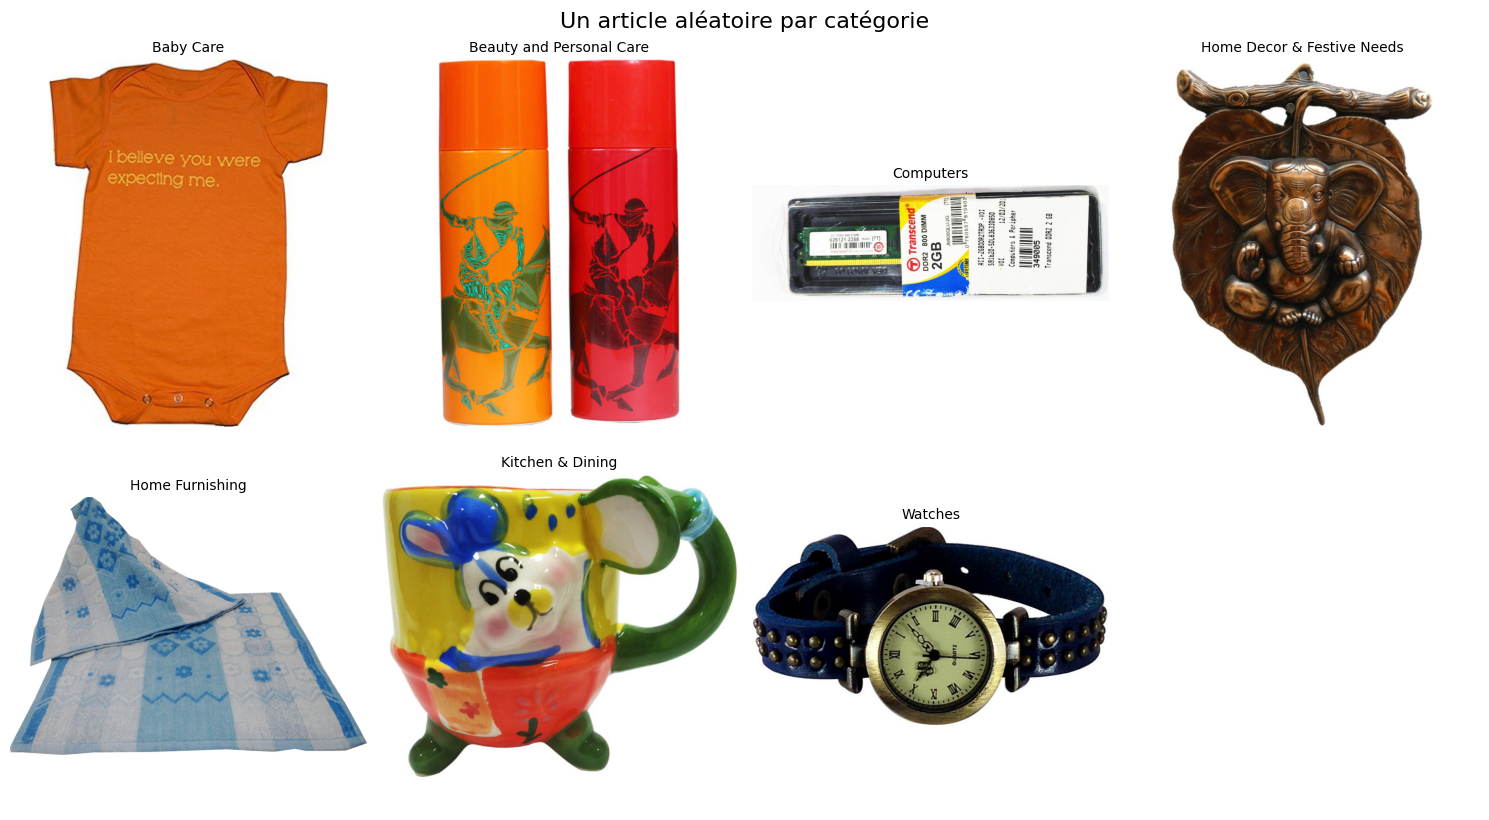

In [7]:
# Get one random sample per category from the balanced dataframe
sampled_products = df.groupby('category').sample(1, random_state=13)

# Sort categories alphabetically for consistent plot order
sampled_products = sampled_products.sort_values('category')

# Create the plot
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten() # Flatten the 2x4 grid into a 1D array of axes

for i, (index, row) in enumerate(sampled_products.iterrows()):
    image_path = row['image_path']
    category = row['category']

    try:
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(category, fontsize=10)
        axes[i].axis('off')
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        axes[i].set_title(f"Image Error: {category}", fontsize=10)
        axes[i].axis('off')
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        axes[i].set_title(f"Image Error: {category}", fontsize=10)
        axes[i].axis('off')


# Hide the last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Un article aléatoire par catégorie', y=1.02, fontsize=16)
plt.show()


In [8]:
df = df[['pid', 'product_name', 'category', 'image_path']]
df.head()

pid                                       product_name  \
0  CRNEG7BKMFFYHQ8Z  Elegance Polyester Multicolor Abstract Eyelet ...   
1  BTWEGFZHGBXPHZUH                         Sathiyas Cotton Bath Towel   
2  BTWEG6SHXTDB2A2Y                Eurospa Cotton Terry Face Towel Set   
3  BDSEJT9UQWHDUBH4  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  BDSEJTHNGWVGWWQU  Jaipur Print Cotton Floral King sized Double B...   

          category                                         image_path  
0  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...  
1        Baby Care  ../Dataset+projet+pretraitement+textes+images/...  
2        Baby Care  ../Dataset+projet+pretraitement+textes+images/...  
3  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...  
4  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...

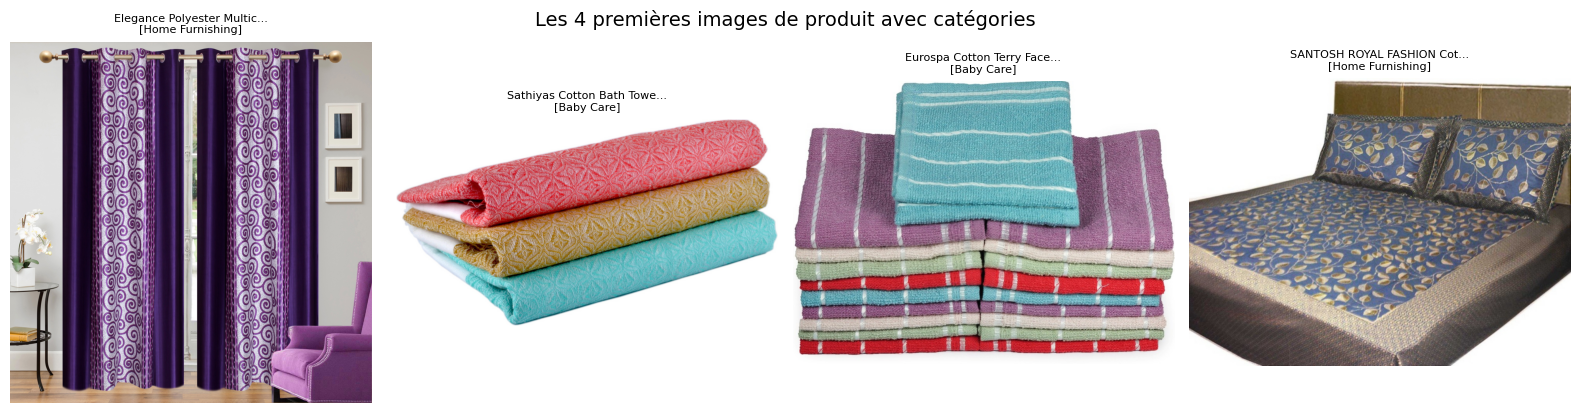

In [9]:
# Affichage des 4 premières images de produit
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    if i < len(df):
        row = df.iloc[i]
        image_path = row['image_path']
        product_name = row['product_name']
        category = row['category']

        try:
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{product_name[:25]}...\n[{category}]", fontsize=8)
            axes[i].axis('off')
        except FileNotFoundError:
            axes[i].text(0.5, 0.5, 'Image\nnot found', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{product_name[:25]}...\n[{category}]", fontsize=8)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error:\n{str(e)[:20]}', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{product_name[:25]}...\n[{category}]", fontsize=8)
            axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Les 4 premières images de produit avec catégories', y=1.02, fontsize=14)
plt.show()

# Split train test

## Initialize folders

In [10]:
# initialiser les répertoires d'images
import os

# Define the paths for the new directories
base_dir = '../Dataset+projet+pretraitement+textes+images/Flipkart/'
train_dir = os.path.join(base_dir, 'dataset_train')
test_dir = os.path.join(base_dir, 'dataset_test')

# Create the new directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):  # si tu veux aussi vider les sous-dossiers
                import shutil
                shutil.rmtree(file_path)
            print(f"Supprimé : {file_path}")
        except Exception as e:
            print(f"Erreur avec {file_path}: {e}")


clear_folder(train_dir)
clear_folder(test_dir)

Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Baby Care
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Beauty and Personal Care
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Computers
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Home Decor & Festive Needs
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Home Furnishing
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Kitchen & Dining
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Watches
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\Baby Care
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\Beauty and Personal Care
Supprimé : ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\Computers
Supprimé : ../Dataset+projet+pretraitement+te

## Copying images to respective folders

In [11]:
# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])

# Define the paths for the new directories
base_dir = '../Dataset+projet+pretraitement+textes+images/Flipkart/'
train_dir = os.path.join(base_dir, 'dataset_train')
test_dir = os.path.join(base_dir, 'dataset_test')

train_df = train_df.copy()  # Create explicit copies
test_df = test_df.copy()

# Create the new directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to move images
def move_images(dataframe, destination_dir):
    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        if image_path and os.path.exists(image_path):
            # Extract the filename from the image_path
            image_filename = os.path.basename(image_path)
            destination_path = os.path.join(destination_dir, image_filename)
            try:
                shutil.copy2(image_path, destination_path)
                row['image_path'] = destination_path  # Update the path in the dataframe
            except Exception as e:
                print(f"Error moving image {image_path} to {destination_path}: {e}")
        else:
            print(f"Image file not found: {image_path}")

# Move images for training set
print("Moving training images...")
move_images(train_df, train_dir)

# Move images for testing set
print("Moving testing images...")
move_images(test_df, test_dir)

# Update the 'image_path' column in the original dataframe
df['image_path'] = df.apply(
    lambda row: os.path.join(train_dir, os.path.basename(row['image_path'])) if row['pid'] in train_df['pid'].values else
                os.path.join(test_dir, os.path.basename(row['image_path'])) if row['pid'] in test_df['pid'].values else
                row['image_path'], axis=1
)


print("Dataset split, images moved, and dataframe updated successfully.")
print(f"Training images moved to: {train_dir}")
print(f"Testing images moved to: {test_dir}")

# Display the updated dataframe (optional)
display(df.head())

Moving training images...
Moving testing images...
Dataset split, images moved, and dataframe updated successfully.
Training images moved to: ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train
Testing images moved to: ../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test


pid                                       product_name  \
0  CRNEG7BKMFFYHQ8Z  Elegance Polyester Multicolor Abstract Eyelet ...   
1  BTWEGFZHGBXPHZUH                         Sathiyas Cotton Bath Towel   
2  BTWEG6SHXTDB2A2Y                Eurospa Cotton Terry Face Towel Set   
3  BDSEJT9UQWHDUBH4  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  BDSEJTHNGWVGWWQU  Jaipur Print Cotton Floral King sized Double B...   

          category                                         image_path  
0  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...  
1        Baby Care  ../Dataset+projet+pretraitement+textes+images/...  
2        Baby Care  ../Dataset+projet+pretraitement+textes+images/...  
3  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...  
4  Home Furnishing  ../Dataset+projet+pretraitement+textes+images/...

In [12]:
df['image_path'].value_counts()

image_path
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\55b85ea15a1536d46b7190ad6fff8ce7.jpg     1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\55195de3873fffaa9e37b041533d7305.jpg     1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\c65fa0b38ab99792630468bd7dd26416.jpg     1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\142994b421c052a6193052c6c8c3d076.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\c6adf41cd378b1f6a7ac62675b060411.jpg    1
                                                                                                            ..
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\26989e846c2096a5b59b59cbea2cc7ab.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\9a02f44389bda4c60e7dc23947dbca58.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\79b78739b0ae84780001fec304ce036c

In [13]:
train_df.shape

(840, 4)

In [14]:
train_df['image_path'].value_counts()

image_path
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\5188dd28a627807407d93549580afb74.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\799ddb97164ff2d5d53bb8b27b8c355f.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\273982a65b9c7dabe56c8345552bfad7.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\526cb1e7675adb39a1ea68f1f2a3fd59.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\984983d05e18e63d1a314e86cb362ae5.jpg    1
                                                                                                            ..
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\e365b55f806e5d0abe0094a9f2590e33.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\85fe188e1ee8237b70df0d475907bf24.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\ed9817e8960a6a0d509061c54cfe5ac1

In [15]:
test_df.shape

(210, 4)

In [16]:
test_df['image_path'].value_counts()

image_path
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\3dfd14b667357e26ff6d66761cdc203f.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\3aaa50eb5d2cf4c18b57346423871624.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\ae03731c3482a5e42d040dbf723c49af.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\ea42376c9c52752d9d01bba12eb2999b.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\227fc5c4fca14c424ff33e40941d22fa.jpg    1
                                                                                                           ..
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\c38eb8abdaa1d8c28bc8c262761dfbc5.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\219b24362655097cb41bf06a0be8ee79.jpg    1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_test\109e235d4838002246599f987d935c21.jpg    1

In [17]:
categories = df['category'].unique()
print(categories)

['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


## Organize images by category

In [18]:
# Configuration pour créer les dossiers par catégorie (si pas déjà fait)
def organize_images_by_category(df, base_path):
    """Organise les images en dossiers par catégorie"""

    # Création des dossiers par catégorie
    for category in df['category'].unique():
        category_path = os.path.join(base_path, category)
        os.makedirs(category_path, exist_ok=True)

    # Déplacer les images dans le bon dossier
    for index, row in df.iterrows():
        image_path = row['image_path']
        category = row['category']

        if image_path and os.path.exists(image_path):
            # Nom du fichier
            image_filename = os.path.basename(image_path)

            # Dossier de destination selon la catégorie
            destination_dir = os.path.join(base_path, category)
            destination_path = os.path.join(destination_dir, image_filename)

            try:
                shutil.move(image_path, destination_path)
                row['image_path'] = destination_path  # Met à jour le chemin dans le dataframe
            except Exception as e:
                print(f"Erreur lors de la copie de {image_path} vers {destination_path}: {e}")
        else:
            print(f"Image introuvable: {image_path}")

    print("Structure des dossiers créée pour les catégories:", df['category'].unique())
    print("Images copiées dans leurs dossiers respectifs.")


organize_images_by_category(train_df, train_dir)
organize_images_by_category(test_df, test_dir)

Structure des dossiers créée pour les catégories: ['Home Furnishing' 'Computers' 'Kitchen & Dining' 'Baby Care'
 'Home Decor & Festive Needs' 'Beauty and Personal Care' 'Watches']
Images copiées dans leurs dossiers respectifs.
Structure des dossiers créée pour les catégories: ['Baby Care' 'Beauty and Personal Care' 'Home Furnishing' 'Watches'
 'Home Decor & Festive Needs' 'Kitchen & Dining' 'Computers']
Images copiées dans leurs dossiers respectifs.


# Structure du dossier de projet:

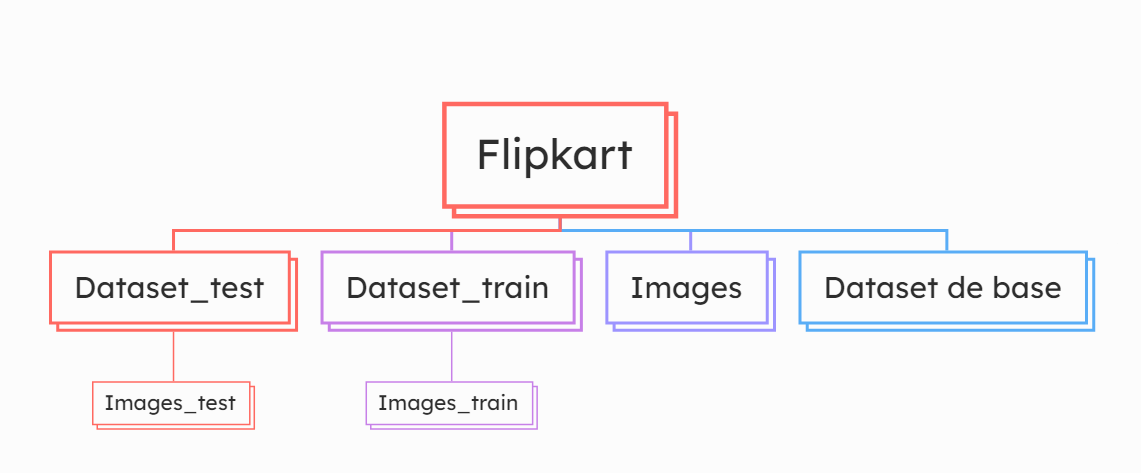

- Flipkart : [drive/MyDrive/OpenclassroomP6/Dataset+projet+pretraitement+textes+images/Flipkart](https://)

In [19]:
# Liste des variables actuelles
# df , train_df, test_df
# base_dir = 'drive/MyDrive/OpenclassroomP6/Dataset+projet+pretraitement+textes+images/Flipkart/'
# train_dir = os.path.join(base_dir, 'dataset_train')
# test_dir = os.path.join(base_dir, 'dataset_test')
# categories = df['category'].unique()


# Split train valid

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

dataset_train = dataset_fct(train_dir, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_dir, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_dir, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [113]:
def dataset_fct_2(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(299, 299), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

dataset_train_inception = dataset_fct_2(train_dir, validation_split=0.25, data_type='training')
dataset_val_inception = dataset_fct_2(train_dir, validation_split=0.25, data_type='validation')
dataset_test_inception = dataset_fct_2(test_dir, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [21]:
import os
from PIL import Image

def check_dataset_modes(dataset_path):
    modes_count = {}
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    mode = img.mode
                    modes_count[mode] = modes_count.get(mode, 0) + 1
                except Exception as e:
                    print(f"Erreur avec {path}: {e}")

    return modes_count

# Exemple d’utilisation

modes = check_dataset_modes(train_dir)
print("train dir :", modes)
modes = check_dataset_modes(test_dir)
print("test dir :", modes)


c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


train dir : {'RGB': 840}
test dir : {'RGB': 210}


In [22]:
train_df['image_path'].value_counts()

image_path
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Home Furnishing\5188dd28a627807407d93549580afb74.jpg               1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Kitchen & Dining\799ddb97164ff2d5d53bb8b27b8c355f.jpg              1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Kitchen & Dining\273982a65b9c7dabe56c8345552bfad7.jpg              1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Home Furnishing\526cb1e7675adb39a1ea68f1f2a3fd59.jpg               1
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Home Decor & Festive Needs\984983d05e18e63d1a314e86cb362ae5.jpg    1
                                                                                                                                       ..
../Dataset+projet+pretraitement+textes+images/Flipkart/dataset_train\Computers\e365b55f806e5d0abe0094a9f2590e33.jpg                     1
../Dataset+projet+pretr

# Preprocess des images

In [23]:
# import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import preprocess_input

# def prepare_dataset(dataset):
#     """Applique uniquement preprocess_input (VGG16)."""

#     def _process_image(image, label):
#         # Prétraitement spécifique à VGG16
#         image = preprocess_input(image)
#         return image, label

#     return dataset.map(_process_image, num_parallel_calls=tf.data.AUTOTUNE)


# dataset_train = prepare_dataset(dataset_train)
# dataset_val = prepare_dataset(dataset_val)
# dataset_test = prepare_dataset(dataset_test)

# Optimisation
# dataset_train = dataset_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# dataset_val = dataset_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# dataset_test = dataset_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Approche normale

## VGG16

### Création de modèle pré entrainé

Faut ajouter le verbose de la data augmentation

In [25]:
def create_VGG16_model() :
    # Data preprocess
    data_preprocess = Sequential([
        Lambda(preprocess_input_vgg16, input_shape=(224, 224, 3)),
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers: # Geler les couches du modèle de base
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_preprocess,
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)), #### # régularisation L2 sur les poids 
                Dropout(0.5),
                Dense(7, activation='softmax',kernel_regularizer=regularizers.l2(1e-4)) #### # Changed to 7 to match the number of categories
                ])


    # --- Définition de l’optimiseur AdamW ---
    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) ####

    print(model.summary())

    return model

model_vgg16 = create_VGG16_model()

# Dossier de sauvegarde
save_dir = "../Runs/VGG16"  
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")

# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_vgg16.load_weights(best_model_path)


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=3,   # si pas d’amélioration après 3 epochs
    verbose=1
)
# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du classifieur final

In [26]:
history = model_vgg16.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1,callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.1596 - loss: 13.5570
Epoch 1: val_loss improved from None to 5.33348, saving model to ../Runs/VGG16\best_model.keras

Epoch 1: val_loss improved from None to 5.33348, saving model to ../Runs/VGG16\best_model_valAcc-0.2619.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1810 - loss: 12.0067 - val_accuracy: 0.2619 - val_loss: 5.3335 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2534 - loss: 8.5157
Epoch 2: val_loss improved from 5.33348 to 3.72879, saving model to ../Runs/VGG16\best_model.keras

Epoch 2: val_loss improved from 5.33348 to 3.72879, saving model to ../Runs/VGG16\best_model_valAcc-0.4095.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2794 - loss: 7.8557 - val_accuracy: 0.4095 - val_loss: 3.7288 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3406 - loss: 6.6496
Epoch 3: val_loss improved from 3.72879 

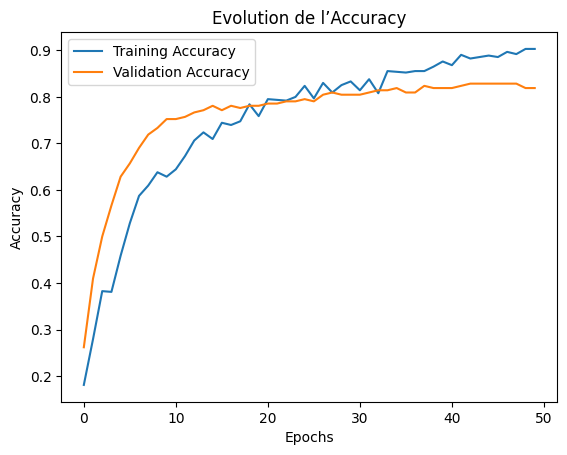

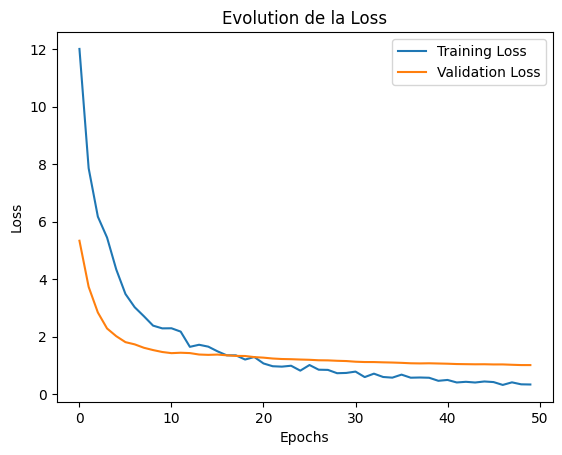

In [27]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [28]:
# model_vgg16.load_weights(os.path.join(save_dir,"best_model_valAcc-0.8143_testAcc-0.7667__preprocess_vgg16.keras")) ####

loss, val_accuracy = model_vgg16.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))
print("loss :", loss)

loss, test_accuracy = model_vgg16.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)

# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")

Validation Accuracy :  0.8190
loss : 1.0073280334472656
Test Accuracy       :  0.7857
loss : 0.9320619702339172
✅ Modèle renommé : ../Runs/VGG16\best_model_valAcc-0.8190_testAcc-0.7857.keras


## ResNet50

### Création de modèle pré entrainé

In [30]:
def create_ResNet50_model():
    # Data preprocess
    data_preprocess = Sequential([
        Lambda(preprocess_input_resnet, input_shape=(224, 224, 3)),  # ✅ on précise ici
    ])

    # Base ResNet50
    model_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    model_base.trainable = False

    # Nouveau modèle
    model = Sequential([
        data_preprocess,
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
    ])

    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.summary()
    return model


model_resnet = create_ResNet50_model()

# Dossier de sauvegarde
save_dir = "../Runs/RESNET" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")


# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_resnet.load_weights(best_model_path) ####



# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=3,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Dans model.fit(..., callbacks=[checkpoint, es, reduce_lr])


# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Entrainement du classifieur final

In [31]:
history = model_resnet.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.1633 - loss: 2.8184
Epoch 1: val_loss improved from None to 1.25838, saving model to ../Runs/RESNET\best_model.keras

Epoch 1: val_loss improved from None to 1.25838, saving model to ../Runs/RESNET\best_model_valAcc-0.6095.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 680ms/step - accuracy: 0.2317 - loss: 2.4129 - val_accuracy: 0.6095 - val_loss: 1.2584 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5038 - loss: 1.4251
Epoch 2: val_loss improved from 1.25838 to 0.90904, saving model to ../Runs/RESNET\best_model.keras

Epoch 2: val_loss improved from 1.25838 to 0.90904, saving model to ../Runs/RESNET\best_model_valAcc-0.7429.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.5667 - loss: 1.2846 - val_accuracy: 0.7429 - val_loss: 0.9090 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6727 - loss: 1.0104
Epoch 3: val_loss improved

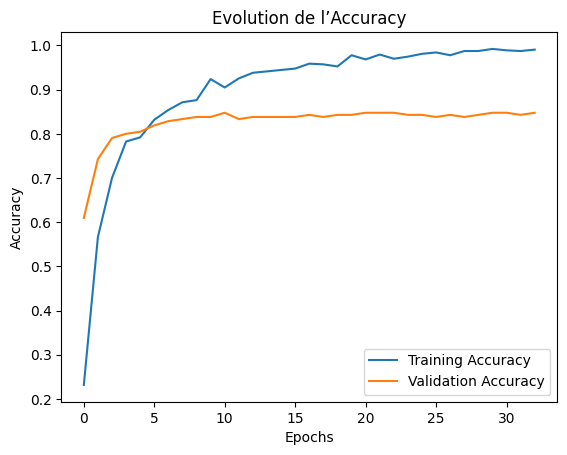

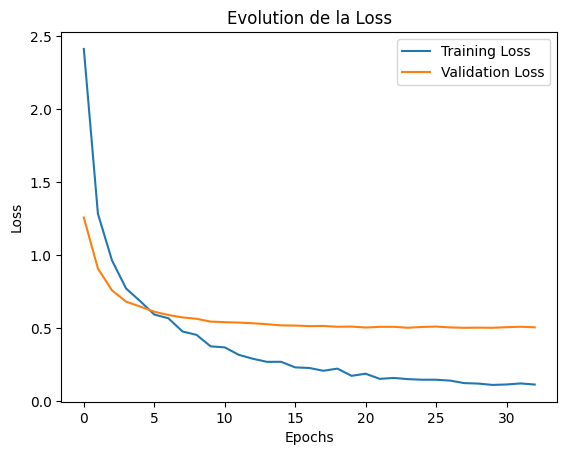

In [32]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [33]:
# model_resnet.load_weights(os.path.join(save_dir,"best_model_valAcc-0.8048_testAcc-0.8143.keras"))

loss, val_accuracy = model_resnet.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_resnet.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")

Validation Accuracy :  0.8476
Test Accuracy       :  0.8238
loss : 0.5716485977172852
✅ Modèle renommé : ../Runs/RESNET\best_model_valAcc-0.8476_testAcc-0.8238.keras


## InceptionV3

### Création de modèle pré entrainé

In [39]:
def create_InceptionV3_model():
    # Data augmentation
    data_augmentation = Sequential([
        Lambda(preprocess_input_inception, input_shape=(299, 299, 3)),
    ])

    # Récupération modèle pré-entraîné
    model_base = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    model_base.trainable = False  # Geler les couches du modèle de base

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))  # 7 classes
    ])

    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())

    return model

model_inception = create_InceptionV3_model()

# Dossier de sauvegarde
save_dir = "../Runs/INCEPTION" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")

# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_inception.load_weights(best_model_path) ####

# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=3,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Dans model.fit(..., callbacks=[checkpoint, es, reduce_lr])


# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,127 (85.18 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Entrainement du classifieur final

In [ ]:
history = model_inception.fit(dataset_train_inception,
                    validation_data=dataset_val_inception,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9853 - loss: 0.1721
Epoch 1: val_loss improved from None to 0.48896, saving model to ../Runs/INCEPTION\best_model.keras

Epoch 1: val_loss improved from None to 0.48896, saving model to ../Runs/INCEPTION\best_model_valAcc-0.8381.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 723ms/step - accuracy: 0.9762 - loss: 0.1866 - val_accuracy: 0.8381 - val_loss: 0.4890 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9739 - loss: 0.1586
Epoch 2: val_loss improved from 0.48896 to 0.48803, saving model to ../Runs/INCEPTION\best_model.keras

Epoch 2: val_loss improved from 0.48896 to 0.48803, saving model to ../Runs/INCEPTION\best_model_valAcc-0.8381.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 689ms/step - accuracy: 0.9698 - l

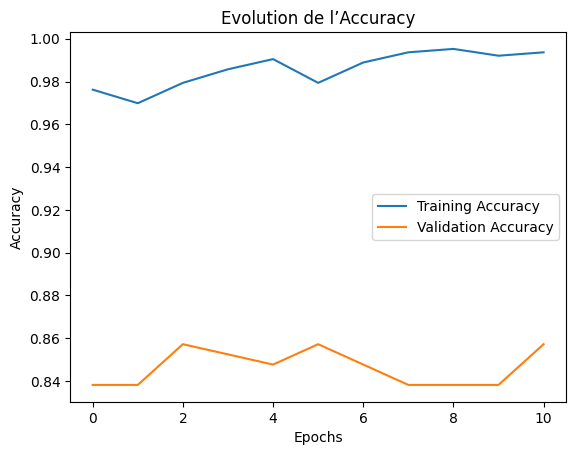

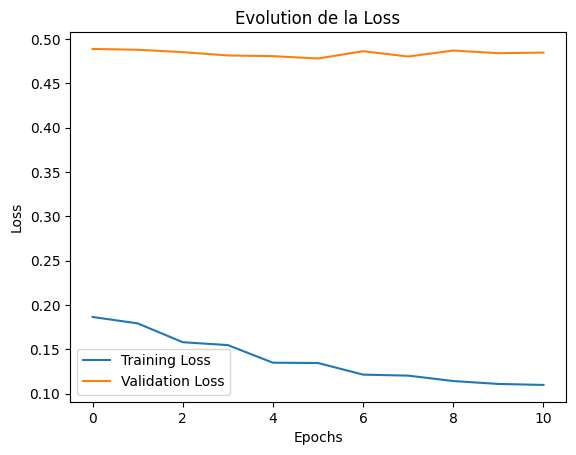

In [41]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [42]:
import os

# model_inception.load_weights("../Runs/INCEPTION/best_model_valAcc-0.7619_testAcc-0.7952.keras")

loss, val_accuracy = model_inception.evaluate(dataset_val_inception, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_inception.evaluate(dataset_test_inception, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")

Validation Accuracy :  0.8571
Test Accuracy       :  0.9000
loss : 0.388963907957077
✅ Modèle renommé : ../Runs/INCEPTION\best_model_valAcc-0.8571_testAcc-0.9000.keras


# Approche Avec DataAugment

## VGG16dt

### Création de modèle pré entrainé

In [23]:
def create_VGG16_model_dt() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers: # Geler les couches du modèle de base
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Lambda(preprocess_input_vgg16),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
                Dropout(0.5),
                Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4)) # Changed to 7 to match the number of categories
                ])

    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())

    return model

# Création du modèle
model_vgg16_dt = create_VGG16_model_dt()

# Dossier de sauvegarde
save_dir = "../Runs/VGG16dt"  ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")


# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_vgg16_dt.load_weights(best_model_path) ####


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=6,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Entrainement du modèle

In [24]:
history = model_vgg16_dt.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1340 - loss: 10.2388
Epoch 1: val_loss improved from None to 4.93424, saving model to ../Runs/VGG16dt\best_model.keras

Epoch 1: val_loss improved from None to 4.93424, saving model to ../Runs/VGG16dt\best_model_valAcc-0.2571.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.1540 - loss: 9.1831 - val_accuracy: 0.2571 - val_loss: 4.9342 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2120 - loss: 7.5198
Epoch 2: val_loss improved from 4.93424 to 3.53438, saving model to ../Runs/VGG16dt\best_model.keras

Epoch 2: val_loss improved from 4.93424 to 3.53438, saving model to ../Runs/VGG16dt\best_model_valAcc-0.3952.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.2333 - loss: 7.1941 - val_accuracy: 0.3952 - val_loss: 3.5344 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2733 - loss: 6.1374
Epoch 3: val_loss improved from 3.53

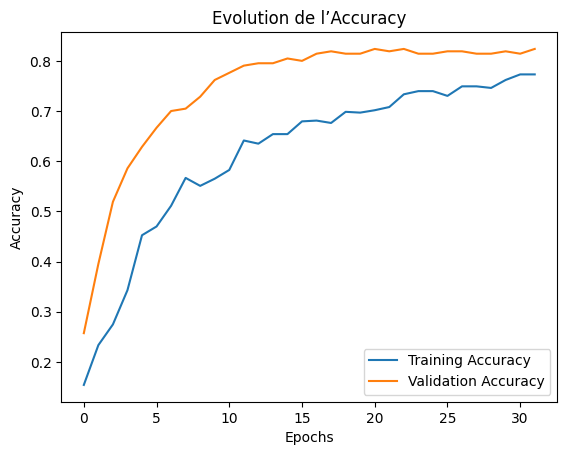

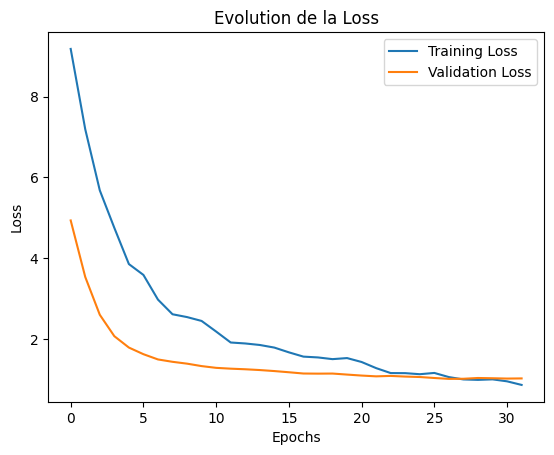

In [25]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [26]:
# === Ton code de test ===
loss, val_accuracy = model_vgg16_dt.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_vgg16_dt.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")


Validation Accuracy :  0.8238
Test Accuracy       :  0.7857
loss : 1.0992921590805054
✅ Modèle renommé : ../Runs/VGG16dt\best_model_valAcc-0.8238_testAcc-0.7857.keras


## ResNet50dt

### Création du modèle

In [71]:
def create_ResNet50_model_dt():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # Récupération modèle pré-entraîné
    model_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    model_base.trainable = False  # Geler les couches du modèle de base

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Lambda(preprocess_input_resnet),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))  # 7 classes comme dans ton exemple
    ])

    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())

    return model


model_resnet_dt = create_ResNet50_model_dt()


# Dossier de sauvegarde
save_dir = "../Runs/RESNETdt" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")


# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_resnet_dt.load_weights(best_model_path) ####


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=6,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_43 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


### Entrainement du modèle

In [73]:
model_resnet_dt.optimizer.learning_rate=1e-4
history = model_resnet_dt.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.2754 - loss: 2.1540
Epoch 1: val_loss improved from 1.93536 to 1.23139, saving model to ../Runs/RESNETdt\best_model.keras

Epoch 1: val_loss improved from 1.93536 to 1.23139, saving model to ../Runs/RESNETdt\best_model_valAcc-0.5714.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 634ms/step - accuracy: 0.3190 - loss: 1.9807 - val_accuracy: 0.5714 - val_loss: 1.2314 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4839 - loss: 1.5161
Epoch 2: val_loss improved from 1.23139 to 0.91522, saving model to ../Runs/RESNETdt\best_model.keras

Epoch 2: val_loss improved from 1.23139 to 0.91522, saving model to ../Runs/RESNETdt\best_model_valAcc-0.7333.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - accuracy: 0.5286 - loss: 1.4053 - val_accuracy: 0.7333 - val_loss: 0.9152 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6406 - loss: 1.1297
Epoch 3: val

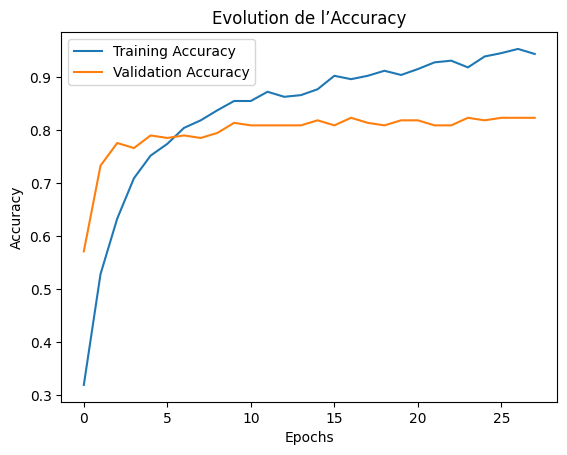

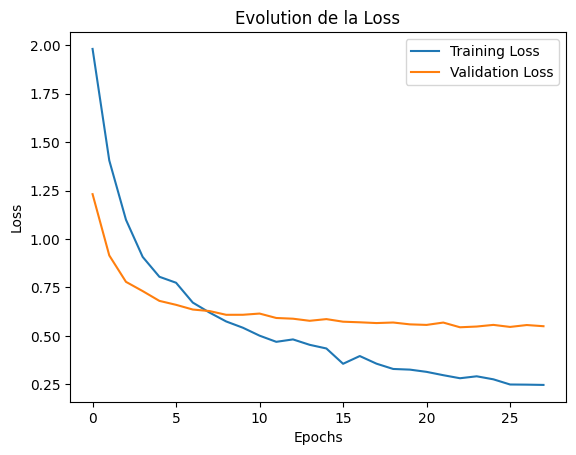

In [74]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [75]:
# === Ton code de test ===
loss, val_accuracy = model_resnet_dt.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_resnet_dt.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")


Validation Accuracy :  0.8238
Test Accuracy       :  0.8190
loss : 0.678560733795166
✅ Modèle renommé : ../Runs/RESNETdt\best_model_valAcc-0.8238_testAcc-0.8190.keras


## InceptionV3dt

### Création du modèle

In [43]:
def create_InceptionV3_model_dt():
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(299, 299, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # Récupération modèle pré-entraîné
    model_base = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    model_base.trainable = False  # Geler les couches du modèle de base

    # Définition du nouveau modèle
    model = Sequential([
        data_augmentation,
        Lambda(preprocess_input_inception),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))  # 7 classes
    ])

    optimizer = AdamW(  ####
        learning_rate=1e-4,  # tu peux réduire à 1e-5 pour du fine-tuning
        weight_decay=1e-4     # correspond au "decay" sur les poids
    )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    print(model.summary())

    return model

model_inception_dt = create_InceptionV3_model_dt()

# Dossier de sauvegarde
save_dir = "../Runs/INCEPTIONdt" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")

# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_inception_dt.load_weights(best_model_path) ####


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=3,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,127 (85.18 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


### Entrainement du modèle

In [44]:
history = model_inception_dt.fit(dataset_train_inception,
                    validation_data=dataset_val_inception,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.1894 - loss: 2.0806
Epoch 1: val_loss improved from None to 1.59457, saving model to ../Runs/INCEPTIONdt\best_model.keras

Epoch 1: val_loss improved from None to 1.59457, saving model to ../Runs/INCEPTIONdt\best_model_valAcc-0.5381.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 753ms/step - accuracy: 0.2492 - loss: 1.9599 - val_accuracy: 0.5381 - val_loss: 1.5946 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.4549 - loss: 1.6288
Epoch 2: val_loss improved from 1.59457 to 1.30374, saving model to ../Runs/INCEPTIONdt\best_model.keras

Epoch 2: val_loss improved from 1.59457 to 1.30374, saving model to ../Runs/INCEPTIONdt\best_model_valAcc-0.6905.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 763ms/step - accuracy: 0.5048 - loss: 1.5364 - val_accuracy: 0.6905 - val_loss: 1.3037 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6252 - loss: 1.2675
Epoch 

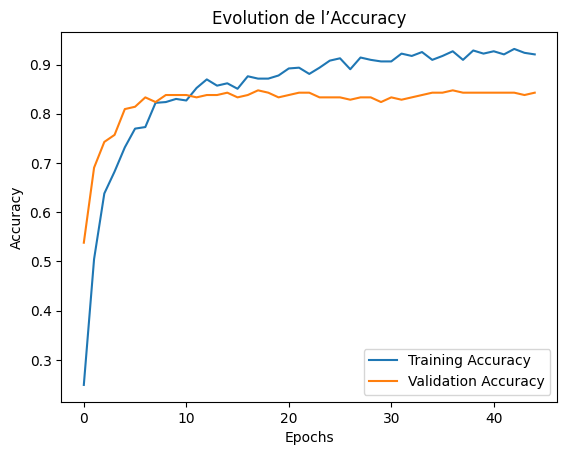

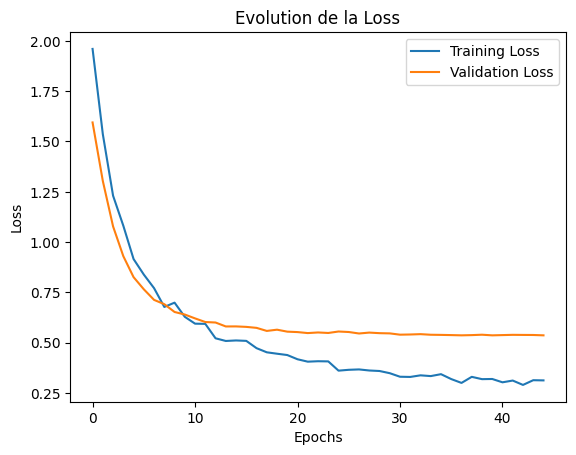

In [45]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

et ajouter la valeur de l'accuracy de test dans le nom du fichier des poids du modèle

In [46]:
import os

# === Ton code de test ===
loss, val_accuracy = model_inception_dt.evaluate(dataset_val_inception, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_inception_dt.evaluate(dataset_test_inception, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_dt
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")



Validation Accuracy :  0.8429
Test Accuracy       :  0.8667
loss : 0.5079149603843689
✅ Modèle renommé : ../Runs/INCEPTIONdt\best_model_valAcc-0.8429_testAcc-0.8667.keras


# Approche FineTunning

## VGG16ft

### Création de modèle pré entrainé

In [34]:
def create_VGG16_model_ft():
    # --- Data augmentation ---
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # --- Chargement du modèle de base ---
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # --- Dégeler les 6 dernières couches ---
    for layer in model_base.layers[:-6]:
        layer.trainable = False
    for layer in model_base.layers[-6:]:
        layer.trainable = True
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = regularizers.l2(1e-5)

    # --- Reconstruction du modèle complet ---
    model = Sequential([
        data_augmentation,
        Lambda(preprocess_input_vgg16, input_shape=(224, 224, 3)),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
    ])

    # --- Optimiseur AdamW ---
    optimizer = AdamW(
        learning_rate=1e-5,  # plus sûr pour du fine-tuning
        weight_decay=1e-4
    )

    # --- Compilation ---
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    # --- Résumé ---
    model.summary()

    print("\n✅ Couches dégelées avec régularisation L2 :")
    for layer in model_base.layers[-10:]:
        if hasattr(layer, 'kernel_regularizer'):
            print(f"{layer.name:25s} | trainable={layer.trainable} | regularizer={layer.kernel_regularizer}")

    return model


# === Création du modèle ===
model_vgg16_ft = create_VGG16_model_ft()

# === Préparation des callbacks ===
save_dir = "../Runs/VGG16ft"
os.makedirs(save_dir, exist_ok=True)

best_model_path = os.path.join(save_dir, "best_model.keras")
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

if os.path.exists(best_model_path):
    model_vgg16_ft.load_weights(best_model_path)

checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=1
)

callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]


c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 9,572,359 (36.52 MB)

 Non-trainable params: 5,275,456 (20.12 MB)


✅ Couches dégelées avec régularisation L2 :
block3_conv3              | trainable=False | regularizer=None
block4_conv1              | trainable=False | regularizer=None
block4_conv2              | trainable=False | regularizer=None
block4_conv3              | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018E0F63C830>
block5_conv1              | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018E0F63DAC0>
block5_conv2              | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018EA0414530>
block5_conv3              | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018E977DF5F0>


c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Entrainement du modèle

In [ ]:
history = model_vgg16_ft.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7658 - loss: 0.9396
Epoch 1: val_loss improved from None to 0.92071, saving model to ../Runs/VGG16ft\best_model.keras

Epoch 1: val_loss improved from None to 0.92071, saving model to ../Runs/VGG16ft\best_model_valAcc-0.8190.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7460 - loss: 0.9692 - val_accuracy: 0.8190 - val_loss: 0.9207 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7830 - loss: 0.8128
Epoch 2: val_loss improved from 0.92071 to 0.88333, saving model to ../Runs/VGG16ft\best_model.keras

Epoch 2: val_loss improved from 0.92071 to 0.88333, saving model to ../Runs/VGG16ft\best_model_valAcc-0.8143.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7571 - loss: 0.8666 - val_accuracy: 0.8143 - val_loss: 0.8833 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7620 - loss: 0.7668
Epoch 3: val_loss improved from 0.883

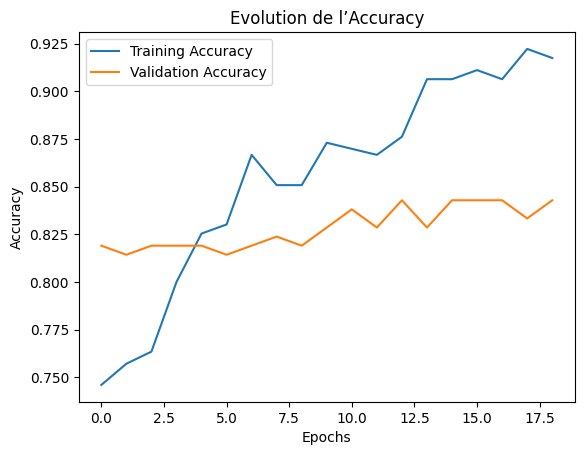

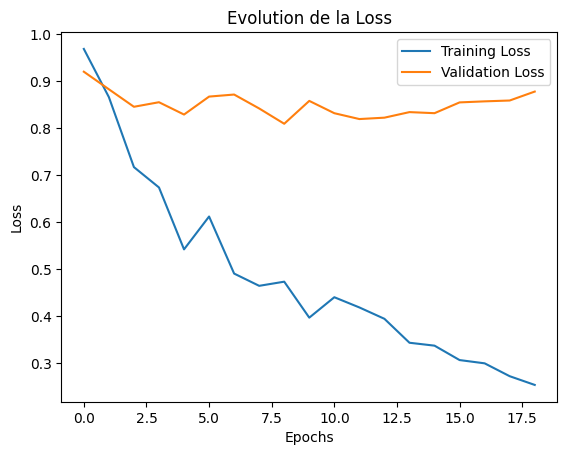

In [36]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [37]:
# === Ton code de test ===
loss, val_accuracy = model_vgg16_ft.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_vgg16_ft.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")

Validation Accuracy :  0.8429
Test Accuracy       :  0.8000
loss : 1.095390796661377
⚠️ Fichier introuvable : ../Runs/VGG16ft\best_model_valAcc-0.8429.keras


## ResNet50ft

### Création du modèle

In [ ]:
def create_ResNet50_model_ft():
    # --- Data augmentation ---
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # --- Base ResNet50 ---
    model_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # --- Dégel à partir de conv4_block6_out (≈15M trainables) ---
    set_trainable = False
    for layer in model_base.layers:
        if layer.name == "conv4_block6_out":
            set_trainable = True
        layer.trainable = set_trainable

    # --- Régularisation L2 sur couches CNN dégelées ---
    for layer in model_base.layers:
        if layer.trainable and isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = regularizers.l2(1e-5)

    # --- Nouveau modèle ---
    model = Sequential([
        data_augmentation,
        Lambda(preprocess_input_resnet, input_shape=(224, 224, 3)),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
    ])

    optimizer = AdamW(
        learning_rate=1e-5,
        weight_decay=1e-4
        )
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.summary()
    # --- Infos ---
    total_params = model.count_params()
    trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable_params = total_params - trainable_params

    print(f"\n📊 Total params       : {total_params:,}")
    print(f"✅ Trainable params   : {trainable_params:,}")
    print(f"🧊 Non-trainable params: {non_trainable_params:,}\n")

    print("\nDernières couches CNN dégelées du model ReNet50 de base :")
    for layer in model_base.layers[-10:]:
        reg = getattr(layer, "kernel_regularizer", None)  # renvoie None si l'attribut n'existe pas
        print(f"{layer.name:30s} | trainable={layer.trainable} | regularizer={reg}")

    return model


# === Création du modèle ===
model_resnet_ft = create_ResNet50_model_ft()

# Dossier de sauvegarde
save_dir = "../Runs/RESNETft" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")


# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_resnet_ft.load_weights(best_model_path) ####


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=6,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_39 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_18 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 15,502,343 (59.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)


📊 Total params       : 24,114,055
✅ Trainable params   : 15,502,343
🧊 Non-trainable params: 8,611,712


Dernières couches CNN dégelées du model ReNet50 de base :
conv5_block3_1_conv            | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018EB11EC470>
conv5_block3_1_bn              | trainable=True | regularizer=None
conv5_block3_1_relu            | trainable=True | regularizer=None
conv5_block3_2_conv            | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018EA58F65D0>
conv5_block3_2_bn              | trainable=True | regularizer=None
conv5_block3_2_relu            | trainable=True | regularizer=None
conv5_block3_3_conv            | trainable=True | regularizer=<keras.src.regularizers.regularizers.L2 object at 0x0000018EAF9F2720>
conv5_block3_3_bn              | trainable=True | regularizer=None
conv5_block3_add               | trainable=True | regularizer=None
conv5_block3_out               | traina

c:\Users\kamel\Documents\Openclassroom_projets\P6\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Entrainement du modèle

In [ ]:
history = model_resnet_ft.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6820 - loss: 0.9907
Epoch 1: val_loss improved from None to 0.67246, saving model to ../Runs/RESNETft\best_model.keras

Epoch 1: val_loss improved from None to 0.67246, saving model to ../Runs/RESNETft\best_model_valAcc-0.8143.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 810ms/step - accuracy: 0.7079 - loss: 0.9669 - val_accuracy: 0.8143 - val_loss: 0.6725 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7387 - loss: 0.8570
Epoch 2: val_loss improved from 0.67246 to 0.66272, saving model to ../Runs/RESNETft\best_model.keras

Epoch 2: val_loss improved from 0.67246 to 0.66272, saving model to ../Runs/RESNETft\best_model_valAcc-0.8095.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 769ms/step - accuracy: 0.7333 - loss: 0.8746 - val_accuracy: 0.8095 - val_loss: 0.6627 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7522 - loss: 0.8609
Epoch 3: val_loss 

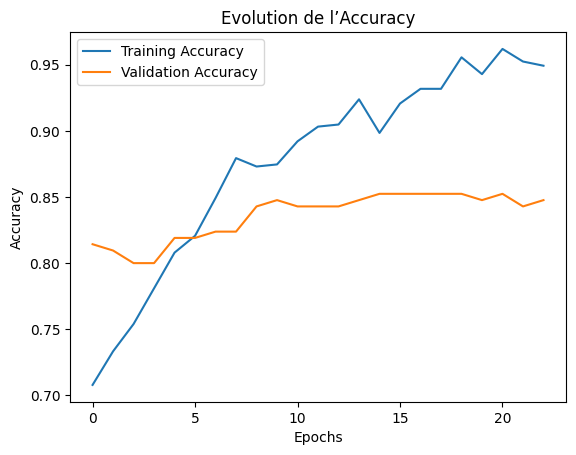

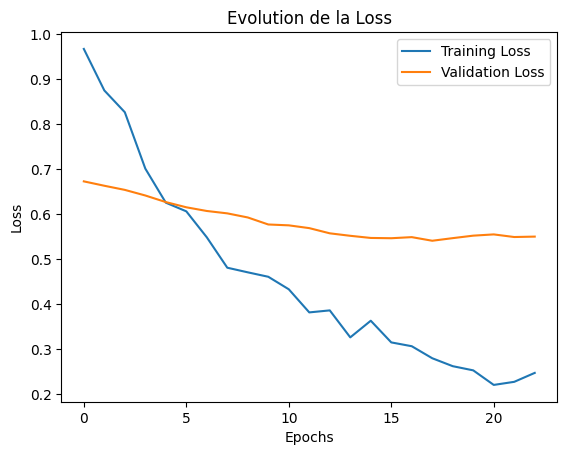

In [49]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [50]:
# === Ton code de test ===
loss, val_accuracy = model_resnet_ft.evaluate(dataset_val, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_resnet_ft.evaluate(dataset_test, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")

Validation Accuracy :  0.8476
Test Accuracy       :  0.8048
loss : 0.7098696827888489
✅ Modèle renommé : ../Runs/RESNETft\best_model_valAcc-0.8476_testAcc-0.8048.keras


## InceptionV3ft

### Création du modèle

In [ ]:
from tensorflow.keras.regularizers import l2
def create_InceptionV3_model_ft():
    # --- Data augmentation ---
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(299, 299, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

    # --- Modèle de base ---
    model_base = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))

    # --- Dégel progressif à partir de mixed7 ---
    set_trainable = False
    for layer in model_base.layers:
        if layer.name == 'mixed7':
            set_trainable = True
        layer.trainable = set_trainable

    # --- Ajout L2 sur les couches convolutionnelles dégelées ---
    for layer in model_base.layers:
        if layer.trainable and isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = l2(1e-5)

    # --- Modèle complet ---
    model = Sequential([
        data_augmentation,
        Lambda(preprocess_input_inception),
        model_base,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(7, activation='softmax', kernel_regularizer=l2(1e-4))
    ])

    # --- Optimiseur ---
    optimizer = AdamW(
        learning_rate=1e-5,
        weight_decay=1e-4
        )

    # --- Compilation ---
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    model.summary()

    print("\nDernières couches CNN dégelées du model inceptionV3 de base :")
    for layer in model_base.layers[-10:]:
        reg = getattr(layer, "kernel_regularizer", None)  # renvoie None si l'attribut n'existe pas
        print(f"{layer.name:30s} | trainable={layer.trainable} | regularizer={reg}")


    return model



model_inception_ft = create_InceptionV3_model_ft()

# Dossier de sauvegarde
save_dir = "../Runs/INCEPTIONft" ####
os.makedirs(save_dir, exist_ok=True)

# Nom du fichier principal (meilleur modèle unique)
best_model_path = os.path.join(save_dir, "best_model.keras")

# Fichier versionné avec validation accuracy
versioned_model_path = os.path.join(save_dir, "best_model_valAcc-{val_accuracy:.4f}.keras")

# === Recharge les meilleurs poids si existants ===
if os.path.exists(best_model_path):
    model_inception_ft.load_weights(best_model_path) ####


# Callback : écrase le fichier principal
checkpoint_best = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

# Callback : sauvegarde aussi une version nommée avec la val_accuracy
checkpoint_versioned = ModelCheckpoint(
    filepath=versioned_model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)


# Early stopping classique
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,   # divise le LR par 2
    patience=3,   # si pas d’amélioration après 3 epochs
    verbose=1
)

# Liste des callbacks
callbacks_list = [checkpoint_best, checkpoint_versioned, es, reduce_lr]

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_41 (Sequential)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_19 (Lambda)              │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,127 (85.18 MB)

 Trainable params: 13,338,247 (50.88 MB)

 Non-trainable params: 8,990,880 (34.30 MB)


Dernières couches CNN dégelées du model inceptionV3 de base :
activation_745                 | trainable=True | regularizer=None
activation_746                 | trainable=True | regularizer=None
activation_749                 | trainable=True | regularizer=None
activation_750                 | trainable=True | regularizer=None
batch_normalization_751        | trainable=True | regularizer=None
activation_743                 | trainable=True | regularizer=None
mixed9_1                       | trainable=True | regularizer=None
concatenate_15                 | trainable=True | regularizer=None
activation_751                 | trainable=True | regularizer=None
mixed10                        | trainable=True | regularizer=None


### Entrainement du modèle

In [ ]:
history = model_inception_ft.fit(dataset_train_inception,
                    validation_data=dataset_val_inception,
                    batch_size=batch_size, epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.1287 - loss: 2.2380
Epoch 1: val_loss improved from None to 1.76906, saving model to ../Runs/INCEPTIONft\best_model.keras

Epoch 1: val_loss improved from None to 1.76906, saving model to ../Runs/INCEPTIONft\best_model_valAcc-0.3429.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 957ms/step - accuracy: 0.1698 - loss: 2.1436 - val_accuracy: 0.3429 - val_loss: 1.7691 - learning_rate: 1.0000e-05
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.3440 - loss: 1.8099
Epoch 2: val_loss improved from 1.76906 to 1.51198, saving model to ../Runs/INCEPTIONft\best_model.keras

Epoch 2: val_loss improved from 1.76906 to 1.51198, saving model to ../Runs/INCEPTIONft\best_model_valAcc-0.6571.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 889ms/step - accuracy: 0.3444 - loss: 1.7749 - val_accuracy: 0.6571 - val_loss: 1.5120 - learning_rate: 1.0000e-05
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.4951 - loss: 1.5074
Epoch 

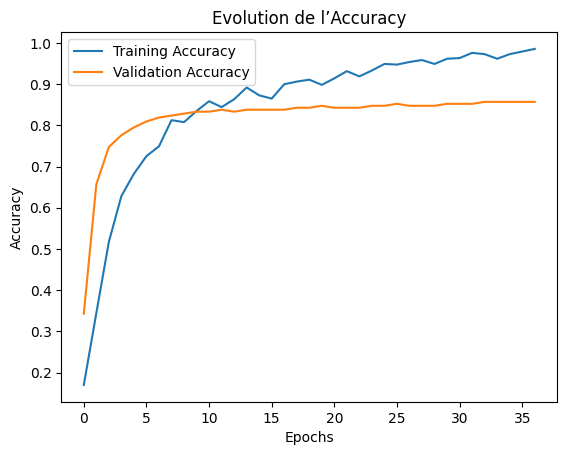

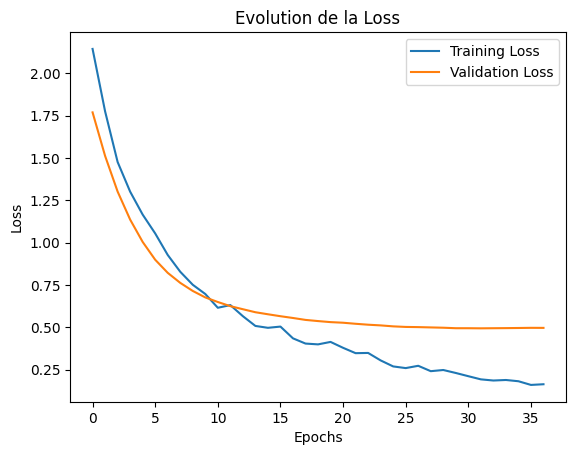

In [69]:
# --- Tracé de l'accuracy ---
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de l’Accuracy')
plt.legend()
plt.show()

# --- Tracé de la loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la Loss')
plt.legend()
plt.show()

### Test du modele

In [83]:
import os

# === Ton code de test ===
loss, val_accuracy = model_inception_ft.evaluate(dataset_val_inception, verbose=False) ####
print("Validation Accuracy :  {:.4f}".format(val_accuracy))

loss, test_accuracy = model_inception_ft.evaluate(dataset_test_inception, verbose=False) ####
print("Test Accuracy       :  {:.4f}".format(test_accuracy))
print("loss :", loss)
# === Renommage du fichier versionné correspondant ===
# Mets ici le chemin du fichier qui a servi à charger model_inception_ft
current_model_path = os.path.join(save_dir, f"best_model_valAcc-{val_accuracy:.4f}.keras")  # <-- à adapter !

if os.path.exists(current_model_path):
    name, ext = os.path.splitext(current_model_path)
    
    # éviter de renommer plusieurs fois
    if "_testAcc" not in name:
        new_model_path = f"{name}_testAcc-{test_accuracy:.4f}{ext}"
        os.rename(current_model_path, new_model_path)
        print(f"✅ Modèle renommé : {new_model_path}")
    else:
        print("↩️ Le fichier contient déjà testAcc dans son nom")
else:
    print(f"⚠️ Fichier introuvable : {current_model_path}")


Validation Accuracy :  0.8571
Test Accuracy       :  0.8667
loss : 0.49189531803131104
⚠️ Fichier introuvable : ../Runs/RESNETdt\best_model_valAcc-0.8571.keras


# Benchmark models

<div style="display: flex;">
  <div style="flex: 1; padding: 10px;">
    <!-- Tableau 1 -->
    <table>
      <tr><th>Approche normale</th></tr>
      <tr><td>Models</td><td>Val accuracy</td><td>Test accuracy</td><td>Test loss</td></tr>
      <tr><td>VGG16</td><td>0.8190</td><td>0.7857</td><td>0.9320</td></tr>
      <tr><td>RESNET50</td><td>0.8476</td><td>0.8238</td><td>0.5716</td></tr>
      <tr><td>INCEPTIONV3</td><td>0.8429</td><td>0.9000</td><td>0.4070</td></tr>
    </table>
  </div>

  <div style="flex: 1; padding: 10px;">
    <!-- Tableau 2 -->
    <table>
      <tr><th>Approche DataAugment</th></tr>
      <tr><td>Models</td><td>Val accuracy</td><td>Test accuracy</td><td>Test loss</td></tr>
      <tr><td>VGG16dt</td><td>0.8238</td><td>0.7857</td><td>1.0992</td></tr>
      <tr><td>RESNET50dt</td><td>0.8238</td><td>0.8190</td><td>0.6785</td></tr>
      <tr><td>INCEPTIONV3dt</td><td>0.8429</td><td>0.8667</td><td>0.5079</td></tr>
    </table>
  </div>

  <div style="flex: 1; padding: 10px;">
    <!-- Tableau 3 -->
    <table>
      <tr><th>Approche FineTuning</th></tr>
      <tr><td>Models</td><td>Val accuracy</td><td>Test accuracy</td><td>Test loss</td></tr>
      <tr><td>VGG16ft</td><td>0.8429</td><td>0.8000</td><td>1.0953</td></tr>
      <tr><td>RESNET50ft</td><td>0.8476</td><td>0.8048</td><td>0.7098</td></tr>
      <tr><td>INCEPTIONV3ft</td><td>0.8571</td><td>0.8667</td><td>0.4918</td></tr>
    </table>
  </div>
</div>




In [110]:
def dataset_fct_inception(path, validation_split=0, data_type=None):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(299, 299),
        shuffle=True,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )
    # ✅ Appliquer le preprocessing InceptionV3 (identique à l'entraînement)
    dataset = dataset.map(lambda x, y: (preprocess_input_inception(x), y))
    return dataset

# === Création des datasets ===
dataset_train_inception = dataset_fct_inception(train_dir, validation_split=0.25, data_type='training')
dataset_val_inception = dataset_fct_inception(train_dir, validation_split=0.25, data_type='validation')
dataset_test_inception = dataset_fct_inception(test_dir, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


# Matrix confusion

In [115]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=(data_type is not None), seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

dataset_train = dataset_fct(train_dir, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_dir, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_dir, validation_split=0, data_type=None)

def dataset_fct_2(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(299, 299), shuffle=(data_type is not None), seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

dataset_train_inception = dataset_fct_2(train_dir, validation_split=0.25, data_type='training')
dataset_val_inception = dataset_fct_2(train_dir, validation_split=0.25, data_type='validation')
dataset_test_inception = dataset_fct_2(test_dir, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.
Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


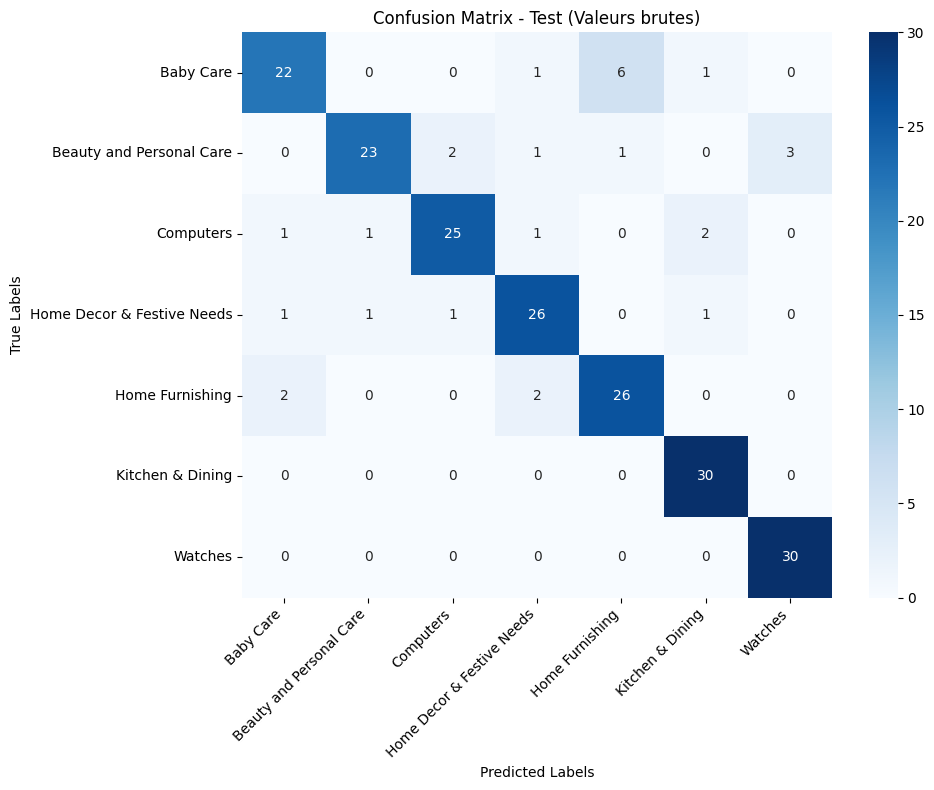


=== Rapport de classification ===

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.73      0.79        30
  Beauty and Personal Care       0.92      0.77      0.84        30
                 Computers       0.89      0.83      0.86        30
Home Decor & Festive Needs       0.84      0.87      0.85        30
           Home Furnishing       0.79      0.87      0.83        30
          Kitchen & Dining       0.88      1.00      0.94        30
                   Watches       0.91      1.00      0.95        30

                  accuracy                           0.87       210
                 macro avg       0.87      0.87      0.86       210
              weighted avg       0.87      0.87      0.86       210



In [116]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === 1️⃣ Récupération des vraies classes et des prédictions ===
y_true_list = []
y_pred_list = []
for x_batch, y_batch in dataset_test_inception:
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(model_inception_ft.predict(x_batch, verbose=0))
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# === 2️⃣ Utiliser l'ordre correct des classes ===
class_names = dataset_test.class_names   # ✅ le vrai ordre des classes du dataset

# === 3️⃣ Créer la matrice de confusion ===
cm = confusion_matrix(y_true_classes, y_pred_classes)

# === 4️⃣ Matrice de confusion brute ===
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test (Valeurs brutes)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# === 6️⃣ Rapport de classification ===
print("\n=== Rapport de classification ===\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


The class the least well predicted is the 'Baby Care' class

# Visualisation de prédictions

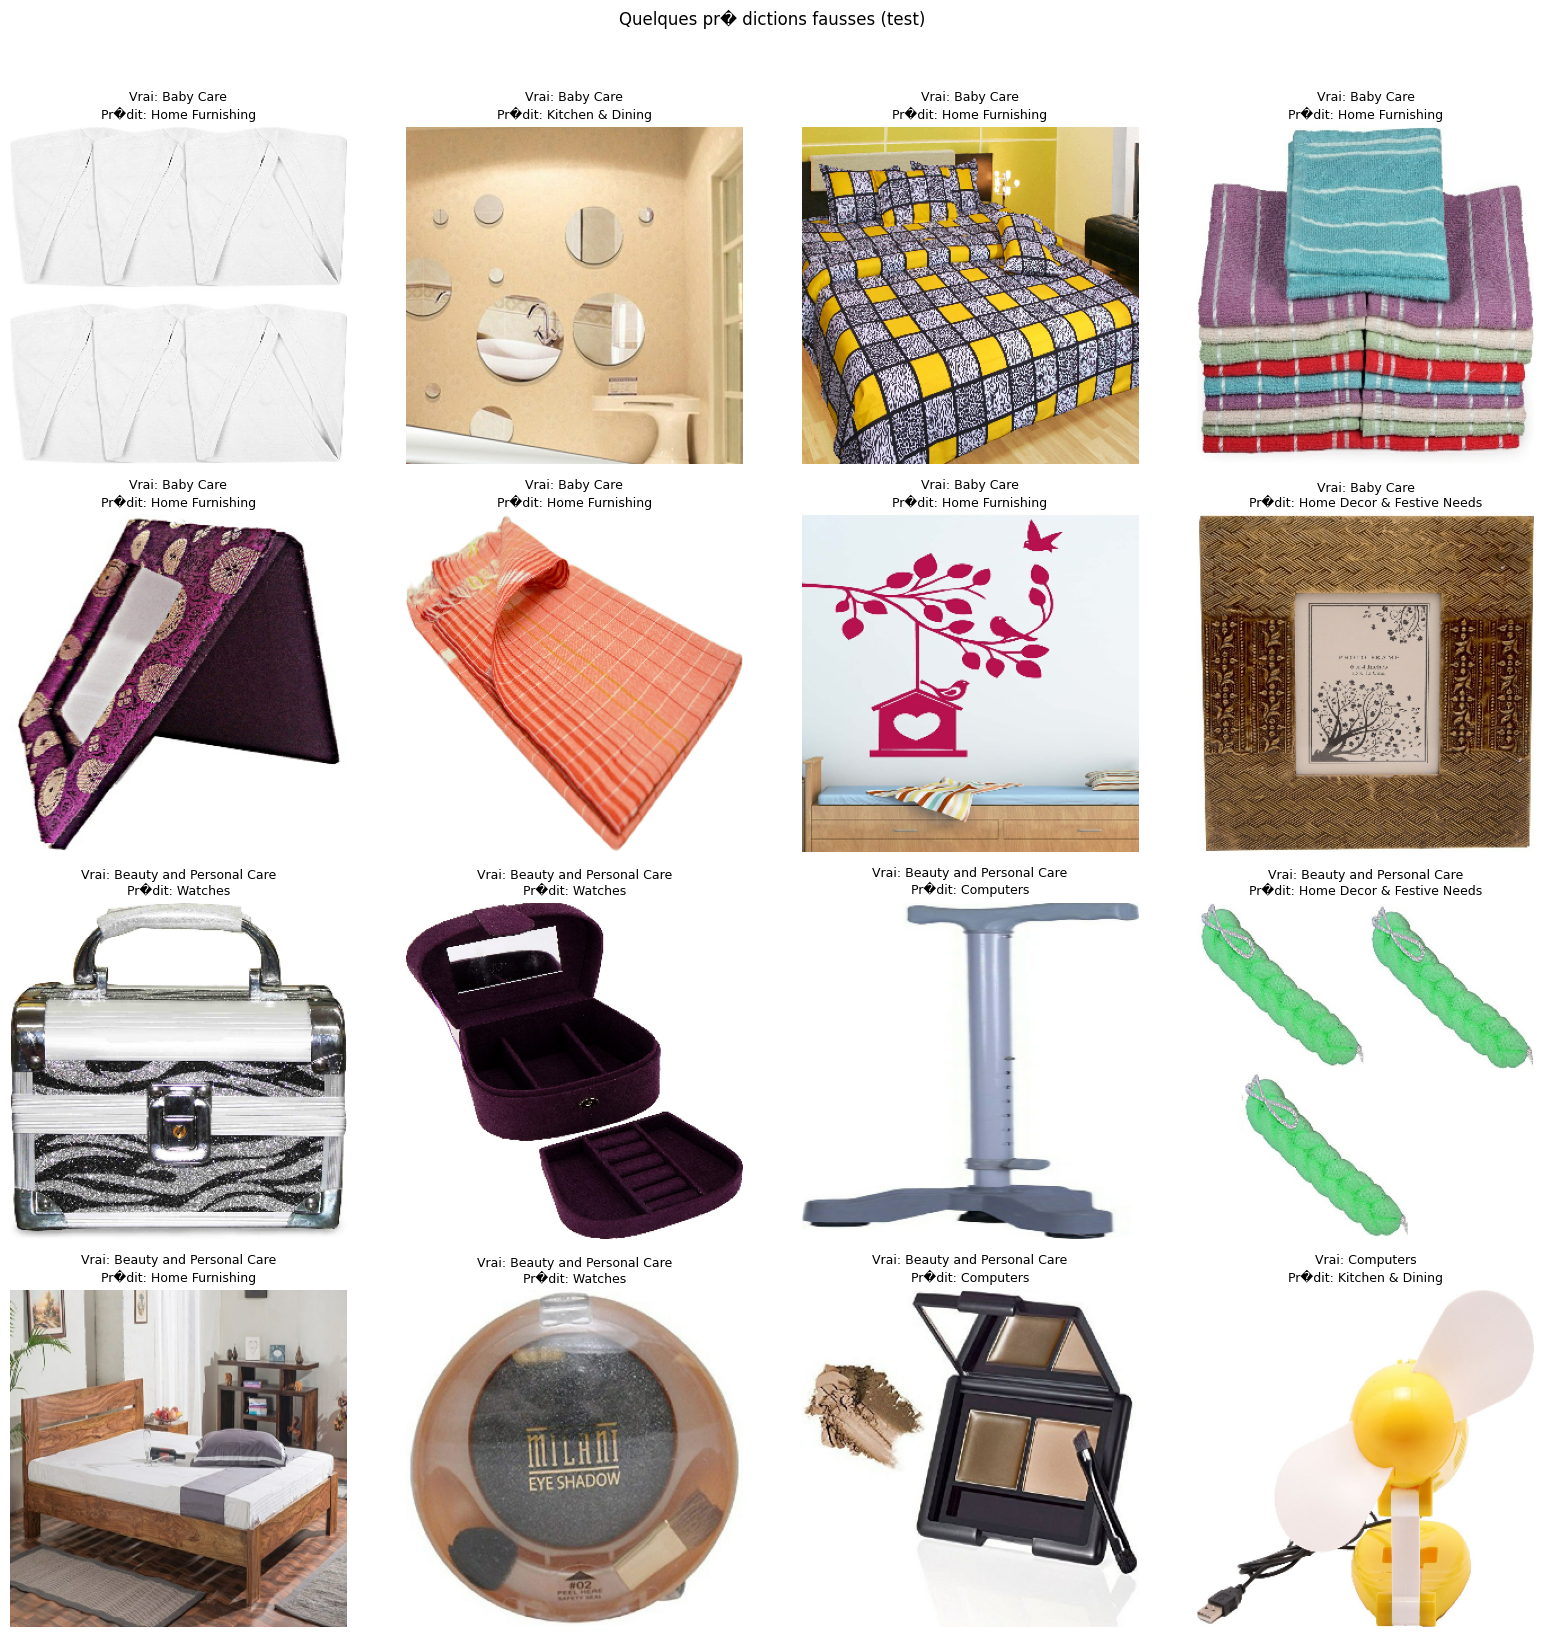

In [122]:
# Affichage de pr�dictions fausses sur le jeu de test
import math

max_to_show = 16
mis_images, mis_true_idx, mis_pred_idx = [], [], []
mis_true_onehot = []
class_names = dataset_test_inception.class_names

for x_batch, y_batch in dataset_test_inception:
    y_true_batch = tf.argmax(y_batch, axis=1).numpy()
    y_pred_probs = model_inception_ft.predict(x_batch, verbose=0)
    y_pred_batch = np.argmax(y_pred_probs, axis=1)
    mism = y_true_batch != y_pred_batch
    if np.any(mism):
        x_mis = x_batch[mism].numpy()
        t_mis = y_true_batch[mism]
        oh_mis = y_batch[mism].numpy()
        p_mis = y_pred_batch[mism]
        for i in range(len(t_mis)):
            mis_images.append(x_mis[i])
            mis_true_idx.append(int(t_mis[i]))
            mis_true_onehot.append(oh_mis[i])
            mis_pred_idx.append(int(p_mis[i]))
            if len(mis_images) >= max_to_show:
                break
    if len(mis_images) >= max_to_show:
        break

if len(mis_images) == 0:
    print("Aucune pr�diction erron�e trouv�e dans l'�chantillon.")
else:
    cols = 4
    rows = math.ceil(len(mis_images) / cols)
    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, img in enumerate(mis_images):
        ax = plt.subplot(rows, cols, i + 1)
        img_disp = np.clip(img / 255.0, 0.0, 1.0)
        plt.imshow(img_disp.astype(np.float32))
        true_label = class_names[mis_true_idx[i]]
        pred_label = class_names[mis_pred_idx[i]]
        ax.set_title(f"Vrai: {true_label}\nPr�dit: {pred_label}", fontsize=9)
        ax.axis('off')
    plt.suptitle("Quelques pr� dictions fausses (test)", y=1.02)
    plt.tight_layout()
    plt.show()


In [123]:
# Verification: check displayed true labels match one-hot labels
import numpy as np

max_check = 32
records = []
class_names = dataset_test_inception.class_names

for x_batch, y_batch in dataset_test_inception:
    y_true_onehot = y_batch.numpy()
    y_true_idx = np.argmax(y_true_onehot, axis=1)
    y_pred_probs = model_inception_ft.predict(x_batch, verbose=0)
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    mism = y_true_idx != y_pred_idx
    if np.any(mism):
        for i in np.where(mism)[0]:
            records.append({
                'true_idx': int(y_true_idx[i]),
                'true_onehot': y_true_onehot[i],
                'pred_idx': int(y_pred_idx[i])
            })
            if len(records) >= max_check:
                break
    if len(records) >= max_check:
        break

ok = True
for k, rec in enumerate(records):
    derived_true = int(np.argmax(rec['true_onehot']))
    if derived_true != rec['true_idx']:
        ok = False
        print(f"Mismatch at {k}: true_idx={rec['true_idx']}, argmax(onehot)={derived_true}")

# Additional checks
if len(records) > 0:
    n_classes = len(class_names)
    if not all(len(rec['true_onehot']) == n_classes for rec in records):
        ok = False
        print("Warning: one-hot size inconsistent with class_names.")

print("True label verification:", "OK" if ok else "INCONSISTENCIES FOUND")


True label verification: OK


In [124]:
# Verification: displayed images have correct true labels
import numpy as np

if 'mis_true_idx' not in globals() or 'mis_true_onehot' not in globals() or len(mis_true_idx) == 0:
    print('Nothing to verify: run the visualization cell first.')
else:
    ok = True
    for i, oh in enumerate(mis_true_onehot):
        derived_true = int(np.argmax(oh))
        if derived_true != int(mis_true_idx[i]):
            ok = False
            print(f'Mismatch at {i}: mis_true_idx={mis_true_idx[i]}, argmax(onehot)={derived_true}')
    if ok:
        print('Displayed true labels: OK')
    else:
        print('Displayed true labels: INCONSISTENCIES FOUND')


Displayed true labels: OK


# End